<a href="https://colab.research.google.com/github/profteachkids/CHE5136_Fall2021/blob/main/PID_Cascade_Optimal_Control_Draining_Tank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Single tank PID level control

The liquid level in a tank with an inflow and gravity drainage is controlled to a desired setpoint $h_{sp}$ by manipulating by an adjustable flow $q_{mv}$ with a proportional - integral - derivative (PID) controller.  A negative $q_{mv}$ indicates that liquid is pumped out of the tank.  The controller parameters are $k_c$, $\tau_i$, and $\tau_d$.

$$A \dfrac{dh}{dt} = q_{in} - C_v \sqrt h + q_{mv} $$

$$ q_{mv} = q_{mv,0} + k_c \left(
  \epsilon + \dfrac{1}{\tau_i} \int_0^t \epsilon \ d \tau  + \dfrac{1}{\tau_d} \dfrac{d\epsilon}{dt}\right)$$ \\

$$h_0 = \left( \dfrac{q_{mv,0} + q_{in,0}}{C_v} \right)^2$$


$$  \epsilon = h - h_{sp}$$


<br><br> 

$$A \dfrac{dh}{dt} = 
  q_{in} - C_v \sqrt h + k_c \left(
  \epsilon + \dfrac{1}{\tau_i} \epsilon_{int}  + \dfrac{1}{\tau_d} \left(\dfrac{dh}{dt} - \dfrac{dh_{sp}}{dt} \right) \right)$$
$$\dfrac{dh}{dt} = \left(\dfrac{1}{A - \frac{k_c}{\tau_d}}\right)
  \left(
    q_{in} - C_v \sqrt h + k_c \left(
  \epsilon + \dfrac{1}{\tau_i} \epsilon_{int}  - \dfrac{1}{\tau_d} \dfrac{dh_{sp}}{dt} \right)
  \right)$$
$$ \dfrac{d \epsilon_{int}}{dt} = \epsilon$$

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import OdeSolution
from scipy.interpolate import interp1d, Akima1DInterpolator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
def dh(t, v, hsp, dhsp, qin, qmv0, A, cv, kc, taui, taud):
  #h = v[0]
  #err_int = v[1]

  err = v[0] - hsp
  return [(qin(t) - cv*v[0]**0.5 + qmv0 + kc*(err + v[1]/taui - dhsp/taud))/(A-kc/taud),
          err]

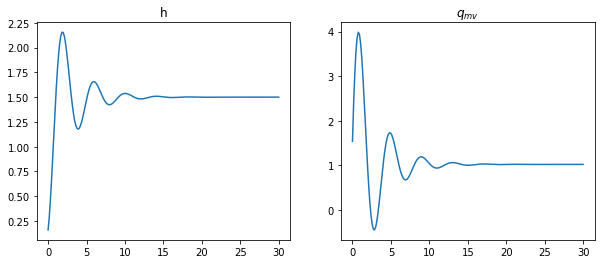

In [ ]:
tend = 30

A = 1
cv = 1
kc = -1
taui = 0.2
taud = 1
hsp = 1.5
dhsp = 0

errint0 = 0

def qin(t):
  return 0.2

qmv0 = 0.2
h0 = ((qin(0)+qmv0)/cv)**2
res = solve_ivp(lambda t,v: dh(t,v, hsp, dhsp, qin, qmv0, A, cv, kc, taui, taud), (0,tend), [h0, errint0], 
                dense_output=True, method='Radau')

t_plot = np.linspace(0,tend, 200)
fig1, ax1 = plt.subplots(1,2, figsize=(10,4))
h = res.sol(t_plot)[0]
err_int = res.sol(t_plot)[1]
err = h-hsp
qmv = qmv0+kc*(err + err_int/taui - dhsp/taud)
ax1[0].plot(t_plot,h)
ax1[0].title.set_text('h')

ax1[1].plot(t_plot,qmv)
ax1[1].title.set_text('$q_{mv}$')

### 2 Interacting Tanks In Series
Flow between tanks set by difference in height of fluid in the two tanks.  Setpoint on height of fluid in second tank.

$$A_1 \dfrac{dh_1}{dt} = 
  q_{in} - C_{v1} \sqrt{h_1-h_2} + q_{mv}
$$

$$q_{mv} = q_{mv0} + k_c \left(
  \epsilon + \dfrac{1}{\tau_i} \epsilon_{int}  + \dfrac{1}{\tau_d} \left(\dfrac{dh_2}{dt} - \dfrac{dh_{sp}}{dt} \right) \right)$$

$$A_2 \dfrac{dh_2}{dt} = 
  C_{v1} \sqrt{h_1-h_2} - C_{v2} \sqrt{h_2}
$$

$$ \epsilon = h_2 - h_{sp}$$

$$ \dfrac{d \epsilon_{int}}{dt} = \epsilon$$

$$ h_{2,0} = \left( \dfrac{q_{in,0} + q_{mv,0}}{C_{v2}} 
\right)^2$$

$$h_{1,0} = h_{2,0} \left( \left( \dfrac{C_{v,2}}{C_{v,1}} \right)^2  +1 \right)$$

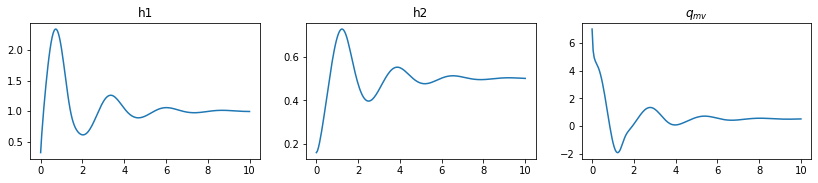

In [ ]:
def d2tanks(t, v, hsp, dhsp, qin, qmv0, A1, A2, cv1, cv2, kc, taui, taud):
  #h1 = v[0]
  #h2 = v[1]
  #err_int = v[2]

  err = v[1] - hsp
  q12 = cv1 * (v[0]-v[1])**0.5
  dh2 = (q12 - cv2*v[1]**0.5)/A2
  dh1 = (qin(t) - q12 + qmv0+ kc*(err + v[2]/taui + (dh2-dhsp)/taud))/A1

  return [dh1, dh2, err]

tend = 10
A1 = 1
A2 = 1
cv1 = 1
cv2 = 1
kc = -20
taui = 0.3
taud = 2
hsp = 0.5
dhsp = 0

qmv0 = 0.2
errint0 = 0

def qin(t):
  return 0.2

h2_0 = ((qin(0)+qmv0)/cv2)**2 
h1_0 = h2_0 * ((cv2/cv1)**2 +1 )

res = solve_ivp(lambda t,v: d2tanks(t,v, hsp, dhsp, qin, qmv0, A1, A2, cv1, cv2, kc, taui, taud), 
                (0,tend), [h1_0, h2_0, errint0], dense_output=True, method='Radau')

t_plot = np.linspace(0,tend, 200)
fig2, ax2 = plt.subplots(1,3, figsize=(14,2.5))
h1 = res.sol(t_plot)[0]
h2 = res.sol(t_plot)[1]
errint = res.sol(t_plot)[2]
ax2[0].plot(t_plot, h1)
ax2[0].title.set_text('h1')

ax2[1].plot(t_plot, h2)
ax2[1].title.set_text('h2')

err = h2 - hsp
q12 = cv1 * (h1-h2)**0.5
dh2 = (q12 - cv2*h2**0.5)/A2
qmv = qmv0+kc*(err + errint/taui + (dh2-dhsp)/taud)

ax2[2].plot(t_plot, qmv)
ax2[2].title.set_text('$q_{mv}$')

### PID control with noise

Sinusoidal noise in the inflow: $q_{in} = 0.2 + 0.05*np.sin(5t)$ is countered effectively by the PID controller which drives the manipulated flow to be approximately opposite in phase.

(0, 1)

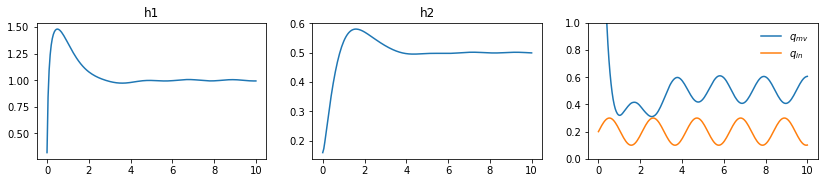

In [ ]:
def qin(t):
  return 0.2+0.1*np.sin(3*t)

tend = 10
A1 = 1
A2 = 1
cv1 = 1
cv2 = 1
kc = -50
taui = 1
taud = 2
hsp = 0.5
dhsp = 0

qmv0 = 0.2
errint0 = 0

h2_0 = ((qin(0)+qmv0)/cv2)**2 
h1_0 = h2_0 * ((cv2/cv1)**2 +1 )

res = solve_ivp(lambda t,v: d2tanks(t,v, hsp, dhsp, qin, qmv0, A1, A2, cv1, cv2, kc, taui, taud), 
                (0,tend), [h1_0, h2_0, errint0], dense_output=True, method='Radau')


t_plot = np.linspace(0,tend, 200)
fig3, ax3 = plt.subplots(1,3, figsize=(14,2.5))
h1 = res.sol(t_plot)[0]
h2 = res.sol(t_plot)[1]
errint = res.sol(t_plot)[2]
ax3[0].plot(t_plot, h1)
ax3[0].title.set_text('h1')

ax3[1].plot(t_plot, h2)
ax3[1].title.set_text('h2')

err = h2 - hsp
q12 = cv1 * (h1-h2)**0.5
dh2 = (q12 - cv2*h2**0.5)/A2
qmv = qmv0+kc*(err + errint/taui + (dh2-dhsp)/taud)

ax3[2].plot(t_plot, qmv, label='$q_{mv}$')
ax3[2].plot(t_plot, qin(t_plot), label='$q_{in}$')
ax3[2].legend(frameon=False)
ax3[2].set_ylim(0,1)

### Cascade Control
The control action on the manipulated flow into Tank 1 takes time to propagate to the measured height of Tank 2.  A significant improvement in controller performance is achievable using a master-slave control strategy.  In this so-called _cascade control_ strategy, the liquid height in Tank 1 is controlled by a slave P-only controller which takes as setpoint the response from a master PI-controller on Tank 2.  

Tank 1:
$$A_1 \dfrac{dh_1}{dt} = 
  q_{in} - C_{v1} \sqrt{h_1-h_2} + q_{mv}
$$

$$q_{mv} = q_{mv,0} + k_{1c} \left(h_1 - h_{1sp} \right) $$

$$A_2 \dfrac{dh_2}{dt} = 
  C_{v1} \sqrt{h_1-h_2} - C_{v2} \sqrt{h_2}
$$

$$h_{1sp} = h_{1sp,0} + k_{2,c} \left(\epsilon + \dfrac{1}{\tau_{2,i}} \epsilon _{int} \right)$$

$$ \epsilon = h_2 - h_{2,sp}$$

$$ \dfrac{d \epsilon_{int}}{dt} = \epsilon$$

$$ h_{2,0} = \left( \dfrac{q_{in,0} + q_{mv,0}}{C_{v2}} 
\right)^2$$

$$h_{1,0} = h_{2,0} \left( \left( \dfrac{C_{v,2}}{C_{v,1}} \right)^2  +1 \right)$$

$$h_{1sp,0} = h_{1,0}$$

(-5, 5)

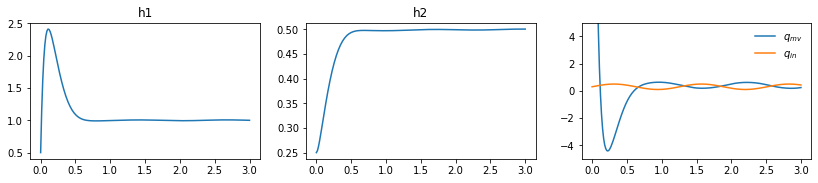

In [ ]:
def d2tanks_cascade_control(t, v, hsp, dhsp, qin, qmv0, h1sp_0, A1, A2, cv1, cv2, k1c, k2c, tau2i):
  #h1 = v[0]
  #h2 = v[1]
  #err_int = v[2]

  err = v[1] - hsp
  h1sp = h1sp_0 + k2c*(err + v[2]/tau2i)
  q12 = cv1 * (v[0]-v[1])**0.5
  dh2 = (q12 - cv2*v[1]**0.5)/A2
  qmv = qmv0+ k1c*(v[0]-h1sp)
  dh1 = (qin(t) - q12 + qmv)/A1

  return [dh1, dh2, err]

tend = 3
A1 = 1
A2 = 1
cv1 = 1
cv2 = 1
k1c = -20
k2c = -10
tau2i = 1
hsp = 0.5
dhsp = 0

errint0 = 0

def qin(t):
  return 0.3+0.2*np.sin(5*t)

qmv0 = 0.2
errint0 = 0

h2_0 = ((qin(0)+qmv0)/cv2)**2 
h1_0 = h2_0 * ((cv2/cv1)**2 +1 )
h1sp_0 = h1_0

res = solve_ivp(lambda t,v: d2tanks_cascade_control(t,v, hsp, dhsp, qin, qmv0, h1sp_0, A1, A2, cv1, cv2, k1c, k2c, tau2i ), 
                (0,tend), [h1_0, h2_0, errint0], dense_output=True, method='Radau')

t_plot = np.linspace(0,tend, 200)
fig4, ax4 = plt.subplots(1,3, figsize=(14,2.5))
h1 = res.sol(t_plot)[0]
h2 = res.sol(t_plot)[1]
errint = res.sol(t_plot)[2]
ax4[0].plot(t_plot, h1)
ax4[0].title.set_text('h1')

ax4[1].plot(t_plot, h2)
ax4[1].title.set_text('h2')

err = h2 - hsp
q12 = cv1 * (h1-h2)**0.5
dh2 = (q12 - cv2*h2**0.5)/A2
h1sp = h1sp_0 + k2c*(err + errint/tau2i)
qmv = qmv0+ k1c*(h1-h1sp)

ax4[2].plot(t_plot, qmv, label='$q_{mv}$')
ax4[2].plot(t_plot, qin(t_plot), label='$q_{in}$')
ax4[2].legend(frameon=False)
ax4[2].set_ylim(-5,5)

### Manipulated Flow Positive Only - Cannot Pump Out

What happens if liquid cannot be pumped out of Tank 1?  In this case, the liquid height in Tank 1 cannot be aggressively increased initially to fill up Tank 2 quickly.  With no means to pump out liquid from Tank 1, this would lead to a significant period of overshoot.  In a straight-line car race where one must pass the finish line at no more than 5 mph, a professional driver cannot do much better than an amateur on a car that has no brakes!

(-0.1, 3)

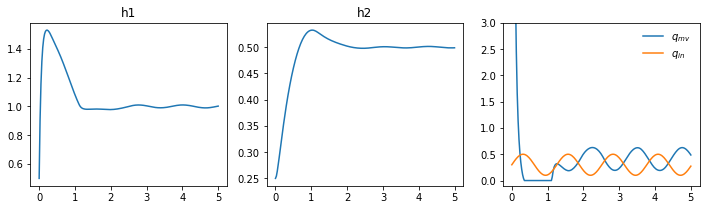

In [ ]:
def d2tanks_cascade_control_positive_only(t, v, hsp, dhsp, qin, qmv0, h1sp_0, A1, A2, cv1, cv2, k1c, k2c, tau2i):
  #h1 = v[0]
  #h2 = v[1]
  #err_int = v[2]

  err = v[1] - hsp
  h1sp = h1sp_0 + k2c*(err + v[2]/tau2i)
  q12 = cv1 * (v[0]-v[1])**0.5
  dh2 = (q12 - cv2*v[1]**0.5)/A2
  qmv = qmv0+ k1c*(v[0]-h1sp)
  qmv = max(qmv, 0)

  dh1 = (qin(t) - q12 + qmv)/A1

  return [dh1, dh2, err]

tend = 5
A1 = 1
A2 = 1
cv1 = 1
cv2 = 1
k1c = -20
k2c = -4
tau2i = 0.4
hsp = 0.5
dhsp = 0

errint0 = 0

def qin(t):
  return 0.3+0.2*np.sin(5*t)

qmv0 = 0.2
errint0 = 0

h2_0 = ((qin(0)+qmv0)/cv2)**2 
h1_0 = h2_0 * ((cv2/cv1)**2 +1 )
h1sp_0 = h1_0

res = solve_ivp(lambda t,v: d2tanks_cascade_control_positive_only(t,v, hsp, dhsp, qin, qmv0, h1sp_0, A1, A2, cv1, cv2, k1c, k2c, tau2i ), 
                (0,tend), [h1_0, h2_0, errint0], dense_output=True, method='Radau')

t_plot = np.linspace(0,tend, 200)
fig5, ax5 = plt.subplots(1,3, figsize=(12,3))
h1 = res.sol(t_plot)[0]
h2 = res.sol(t_plot)[1]
errint = res.sol(t_plot)[2]

ax5[0].plot(t_plot, h1)
ax5[0].title.set_text('h1')

ax5[1].plot(t_plot, h2)
ax5[1].title.set_text('h2')

err = h2 - hsp
q12 = cv1 * (h1-h2)**0.5
dh2 = (q12 - cv2*h2**0.5)/A2
h1sp = h1sp_0 + k2c*(err + errint/tau2i)
qmv = qmv0+ k1c*(h1-h1sp)
qmv = np.where(qmv<0, 0, qmv)

ax5[2].plot(t_plot, qmv, label='$q_{mv}$')
ax5[2].plot(t_plot, qin(t_plot), label='$q_{in}$')
ax5[2].legend(frameon=False)
ax5[2].set_ylim(-0.1,3)

### Optimal Control

As the "ultimate" control strategy, let us consider the situation where we know $q_{in}$ and can freely set the manipulated flow rate between 0 and 6.  Adjusting $q_{mv}$ at, for instance, 10 equally spaced times (knots), and interpolating $q_{mv}$, using an _Akima spline_, to solve the differential equations, we will minimize the sum square deviation between $h_2$ and $h_{sp}$ at, for instance, 30 equally spaced points.

(-0.1, 6)

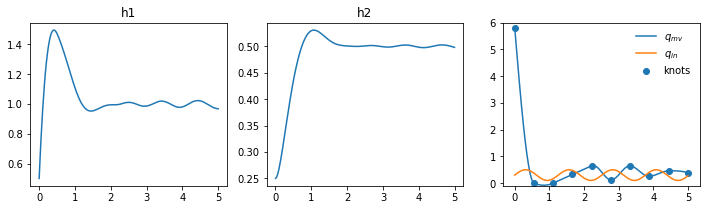

In [ ]:
def d2tanks_optimal_control(t, v, qin, qmv, A1, A2, cv1, cv2):
  #h1 = v[0]
  #h2 = v[1]
  #err_int = v[2]

  q12 = cv1 * (v[0]-v[1])**0.5
  dh2 = (q12 - cv2*v[1]**0.5)/A2

  dh1 = (qin(t) - q12 + qmv(t))/A1

  return [dh1, dh2]

tend = 5
A1 = 1
A2 = 1
cv1 = 1
cv2 = 1

N_knots = 10
t_knots = np.linspace(0,tend, N_knots)


qmv0 = 0.2

def qin(t):
  return 0.3+0.2*np.sin(5*t)

hsp = 0.5
h2_0 = ((qin(0)+qmv0)/cv2)**2 
h1_0 = h2_0 * ((cv2/cv1)**2 +1 )
h1sp_0 = h1_0

def obj(qmv_knots, t_knots):

  qmv = Akima1DInterpolator(t_knots, qmv_knots)

  def qin(t):
    return 0.3+0.2*np.sin(5*t)

  res = solve_ivp(lambda t,v: d2tanks_optimal_control(t,v, qin, qmv, A1, A2, cv1, cv2 ), 
                  (0,tend), [h1_0, h2_0], dense_output=True, method='Radau')

  h2 = res.sol(np.linspace(0,tend,30))[1]
  sumsqerr = np.sum( (h2 - hsp)**2)
  return sumsqerr

#these were 15 knot points were obtained by iterative minimization starting
#with a constant qmv of 0.2 and 4 knots points
#the number of knot points was progressively increased to 10, using the previous
#results to interpolate initial guesses

qmv_knots0 = np.array([5.81078879, 0.        , 0.        , 0.32541692, 0.65101896,
       0.11775769, 0.64968048, 0.25132136, 0.46090424, 0.38973778])

opt_knots = minimize(obj, qmv_knots0, args=t_knots, bounds=[[0,6],]*N_knots)

qmv = Akima1DInterpolator(t_knots, opt_knots.x)
res = solve_ivp(lambda t,v: d2tanks_optimal_control(t,v, qin, qmv, A1, A2, cv1, cv2 ), 
                  (0,tend), [h1_0, h2_0], dense_output=True, method='Radau')


t_plot = np.linspace(0,tend, 200)
fig6, ax6 = plt.subplots(1,3, figsize=(12,3))
h1 = res.sol(t_plot)[0]
h2 = res.sol(t_plot)[1]

ax6[0].plot(t_plot, h1)
ax6[0].title.set_text('h1')

ax6[1].plot(t_plot, h2)
ax6[1].title.set_text('h2')

ax6[2].plot(t_plot, qmv(t_plot), label='$q_{mv}$')
ax6[2].plot(t_plot, qin(t_plot), label='$q_{in}$')
ax6[2].scatter(t_knots, opt_knots.x, label='knots')
ax6[2].legend(frameon=False)
ax6[2].set_ylim(-0.1,6)